# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import numpy as np
import json

REPORT_FILENAME = "/Users/damian/report/report.json"

# don't truncate cell contents when displaying
pd.set_option('display.max_colwidth', -1)

def inspect_url(message_id):
  uri, mid = message_id.split("::")
  return "http://test-6.kite.com:3031/event?uri=%s&message_id=%s" % \
      (urllib.parse.quote(uri), urllib.parse.quote(mid))

def preprocess(obj):
    # If a sub-object is not seen in every object, panda's json_normalize() won't flatten it
    if not obj.get('category', None):
        if obj['failure'] == 'unresolved_value':
            obj['category'] = {'other': True}
        else:
            obj['category'] = {'not_applicable': True}
    
    # If the unresolved function was an attribute, and some prefix of this was resolved
    # to a global symbol, prefix_dist holds the name of the distribution
    prefix_dist = None
    resolves_to = obj['category'].get('prefix_resolves', {}).get('to', None)
    if resolves_to and '@' in resolves_to:
        prefix_dist = resolves_to.split('@')[0]
    obj['prefix_dist'] = prefix_dist
    
    # If the function was resolved but the signature still failed (e.g. no signatures
    # were returned), resolved_dist holds the name of the distribution
    resolved_dist = None
    resolved_symbol = obj['resolved_symbol']
    if resolved_symbol and '@' in resolved_symbol:
        resolved_dist = resolved_symbol.split('@')[0]
    obj['resolved_dist'] = resolved_dist
    
    # If the top-level prefix of the function wasn't resolved, but could have been if a
    # module with that name was imported
    importable_prefix = None
    up = obj['category'].get('unresolved_name', {})
    if up.get('importable', False):
        importable_prefix = up['name']
    obj['importable_prefix'] = importable_prefix
    
    # Bring out the category name as a column
    obj['unresolved'] = obj['category']
    obj['unresolved_category'] = list(obj['unresolved'].keys())[0]
    del obj['category']
    
    # Inspector URL for each event
    obj['inspect'] = inspect_url(obj['message_id'])
    
    return obj
        
def get_signature_data(filename):
    events = [preprocess(json.loads(line))
              for line in open(filename, 'r').readlines()]
    return pd.io.json.json_normalize(events)
    
def render(df):
    def make_clickable(val):
        return '<a href="{}">{}</a>'.format(val, "inspect")
    return df.style.format({'inspect': make_clickable})
    
   
df = get_signature_data(REPORT_FILENAME)
N = len(df.index)

def with_percent(series):
    """Given a series of counts, return a dataframe with a column containing percentages of global count."""
    return pd.DataFrame({'count': series, 'percent': series / len(df.index) * 100})
    
unresolved = df[df['failure'] == 'unresolved_value']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49182 entries, 0 to 49181
Data columns (total 27 columns):
buffer_size                              49182 non-null int64
failure                                  49182 non-null object
func_type                                49182 non-null object
function                                 49182 non-null object
importable_prefix                        1669 non-null object
index_file_count                         49182 non-null int64
index_value_count                        49182 non-null int64
inspect                                  49182 non-null object
message_id                               49182 non-null object
offset                                   49182 non-null int64
outside_parens                           49182 non-null bool
platform                                 49182 non-null object
prefix_dist                              2441 non-null object
region                                   49182 non-null object
resolved_dist    

# Types of failures

In [2]:
(df['failure'].value_counts(normalize=True) * 100).to_frame()

,failure
unresolved_value,50.467651
no_signatures,20.283844
call_expr_outside_parens,12.488309
call_expr_not_found,12.160953
invalid_callee_kind,4.471148
no_context,0.065064
nil_reference,0.063031


## no_signatures

In this case, the symbol was resolved, but not signatures were returned.

In [3]:
render(df[df['failure'] == 'no_signatures'][['function', 'resolved_symbol', 'inspect']].sample(n=30))

,function,resolved_symbol,inspect
26429,len,builtin-stdlib@2.7:__builtin__.int,inspect
26391,pygame.display.set_mode,,inspect
8823,MockSubscription,,inspect
22063,json.loads,builtin-stdlib@2.7:__builtin__.list,inspect
10212,subset.add,,inspect
1739,type,,inspect
41136,e_path.grid,,inspect
20992,button.grid,,inspect
31177,Sum,Django@2.0.1:django.db.models.aggregates.Sum,inspect
26893,mac_to_ip.get,,inspect


In [4]:
# Most common distributions that result in no-signatures cases

with_percent(df[df['failure'] == 'no_signatures']['resolved_dist'].value_counts().nlargest(20))

,count,percent
builtin-stdlib,4447,9.041926
numpy,673,1.368387
Django,143,0.290757
matplotlib,88,0.178927
pandas,88,0.178927
requests,38,0.077264
peewee,19,0.038632
Pygame,19,0.038632
Flask,13,0.026432
mrjob,9,0.018299


In [5]:
# Some builtin no-signature cases

render(df[(df['failure'] == 'no_signatures') & (df['resolved_dist'] == 'builtin-stdlib')][
    ['function', 'resolved_symbol', 'inspect']].sample(n=30))

,function,resolved_symbol,inspect
29010,range,builtin-stdlib@2.7:__builtin__.list,inspect
21433,int,builtin-stdlib@2.7:__builtin__.int,inspect
2954,zip,builtin-stdlib@2.7:__builtin__.list,inspect
26126,plt.plot,builtin-stdlib@2.7:__builtin__.list,inspect
26482,str,builtin-stdlib@2.7:__builtin__.str,inspect
24847,os.system,builtin-stdlib@2.7:__builtin__.int,inspect
32757,ValueError,builtin-stdlib@2.7:exceptions.ValueError,inspect
1584,zip,builtin-stdlib@2.7:__builtin__.list,inspect
2029,pontoPlotar.append,builtin-stdlib@2.7:types.NoneType,inspect
42712,NAND,builtin-stdlib@2.7:__builtin__.int,inspect


## unresolved_value

In this case, the relevant function expression was found but not present in the resolved AST.

In [6]:
# Unresolved value categorization
with_percent(df['unresolved_category'].value_counts())

,count,percent
not_applicable,24361,49.532349
unresolved_name,19374,39.392461
prefix_resolves,4008,8.149323
other,1370,2.785572
resolves,63,0.128096
in_bad_node,6,0.012200


In [7]:
# Some unresolved value events
render(unresolved[['function', 'unresolved_category', 'inspect']].sample(n=15))

,function,unresolved_category,inspect
39314,prit,unresolved_name,inspect
19484,UserForm,unresolved_name,inspect
36375,gsw.distance,unresolved_name,inspect
18090,file.save,unresolved_name,inspect
32962,db.Column,prefix_resolves,inspect
27147,st.encode,unresolved_name,inspect
38369,MailSender,unresolved_name,inspect
4420,Article.objects.filter,unresolved_name,inspect
46605,root.focus,unresolved_name,inspect
19582,auth.get_account_info,unresolved_name,inspect


## prefix_resolves

In this case, the function does not resolve but some prefix does.

In [8]:
render(unresolved[unresolved['unresolved_category'] == 'prefix_resolves'][
    ['function','unresolved.prefix_resolves.prefix', 'unresolved.prefix_resolves.to', 'inspect']].sample(n=15))

,function,unresolved.prefix_resolves.prefix,unresolved.prefix_resolves.to,inspect
7070,models.Charfield,models,Django@2.0.1:django.db.models,inspect
21544,self.assertTrue,self,,inspect
33628,db.relationship,db,Flask-SQLAlchemy@2.3.2:flask_sqlalchemy.SQLAlchemy,inspect
33465,db.Column,db,Flask-SQLAlchemy@2.3.2:flask_sqlalchemy.SQLAlchemy,inspect
40549,app.config.from_object,app,Flask@0.12.2:flask.app.Flask,inspect
14775,self._load_csv_infile,self,,inspect
5712,BookletClient.objects.get,BookletClient,BookletClient,inspect
13857,type.__new__,type,builtin-stdlib@2.7:__builtin__.type,inspect
46297,np.random.choice,np.random,numpy@1.14.0:numpy.random,inspect
47640,player.init,player,player,inspect


## Most common resolved distributions that lead to unresolved values

In [9]:


print("resolved prefix distribution: %f%%" % (
    100 * len(unresolved[unresolved['prefix_dist'].notnull()])/len(df.index)))
with_percent(unresolved['prefix_dist'].value_counts())

resolved prefix distribution: 4.963198%


,count,percent
Flask-SQLAlchemy,843,1.714042
builtin-stdlib,742,1.508682
numpy,349,0.709609
Django,162,0.329389
pandas,130,0.264324
Flask,57,0.115896
tensorflow,48,0.097597
Pygame,38,0.077264
matplotlib,24,0.048798
Scrapy,13,0.026432


### Numpy

In [10]:
print("np.random: %f%%" % (100 * len(df[df['unresolved.prefix_resolves.prefix'] == 'np.random'])/len(df.index)))

def module_prefix_examples(module_name):
    return render(unresolved[unresolved['prefix_dist'] == module_name][
    ['function', 'unresolved.prefix_resolves.prefix', 'unresolved.prefix_resolves.to', 'inspect']].sample(n=30))

module_prefix_examples('builtin-stdlib')

np.random: 0.449351%


,function,unresolved.prefix_resolves.prefix,unresolved.prefix_resolves.to,inspect
41844,random.randrage,random,builtin-stdlib@2.7:random,inspect
20134,data.to_string,data,builtin-stdlib@2.7:__builtin__.dict,inspect
42430,hashlib.md5().update,hashlib.md5(),builtin-stdlib@2.7:__builtin__.str,inspect
10883,food.append,food,builtin-stdlib@2.7:__builtin__.str,inspect
39471,dic[a].append,dic[a],builtin-stdlib@2.7:__builtin__.int,inspect
13657,type.__new__,type,builtin-stdlib@2.7:__builtin__.type,inspect
8656,re.complie,re,builtin-stdlib@2.7:re,inspect
15536,"df_doubt[[1,2,3]].astype","df_doubt[[1,2,3]]",builtin-stdlib@2.7:__builtin__.str,inspect
37344,outdir.mkdir,outdir,builtin-stdlib@2.7:__builtin__.str,inspect
43274,logger.INFO,logger,builtin-stdlib@2.7:logging.getLogger,inspect


### Django

### prefix resolves, but not to a global distribution

In [11]:
render(unresolved[(unresolved['unresolved_category'] == 'prefix_resolves') & (unresolved['prefix_dist'].isna())][
    ['function','unresolved.prefix_resolves.prefix', 'unresolved.prefix_resolves.to', 'inspect']].sample(n=15))

,function,unresolved.prefix_resolves.prefix,unresolved.prefix_resolves.to,inspect
46429,self.plyer.kill,self,,inspect
38443,self.model.objects.create,self,,inspect
47890,self.game.spritesheet.get_image,self,,inspect
47761,self.game.spritesheet.get_image,self,,inspect
47743,self.game.spritesheet.get_image,self,,inspect
27131,self.screen.blit,self,,inspect
22514,self.client.get,self,,inspect
31304,Client.objects.filter,Client,Client,inspect
17922,Log.objects.filter,Log,Log,inspect
31641,self.comments.filter,self,,inspect


In [12]:
module_prefix_examples('Django')

,function,unresolved.prefix_resolves.prefix,unresolved.prefix_resolves.to,inspect
45248,models.IntergerField,models,Django@2.0.1:django.db.models,inspect
10938,admin.site.registe,admin.site,Django@2.0.1:django.contrib.admin.sites.site,inspect
33650,models.Charfield,models,Django@2.0.1:django.db.models,inspect
7612,models.CHarField,models,Django@2.0.1:django.db.models,inspect
30989,admin.site.register_view,admin.site,Django@2.0.1:django.contrib.admin.sites.site,inspect
33703,models.Charfield,models,Django@2.0.1:django.db.models,inspect
45065,models.IntergerField,models,Django@2.0.1:django.db.models,inspect
37332,models.Charfield,models,Django@2.0.1:django.db.models,inspect
7499,self.date.__str__,self.date,Django@2.0.1:django.db.models.fields.DateField,inspect
7216,models.Charfield,models,Django@2.0.1:django.db.models,inspect


## unresolved_name

In this case, there is no prefix of the unresolved function that resolves.

In [13]:
render(unresolved[unresolved['unresolved_category'] == 'unresolved_name'][
    ['function', 'unresolved.unresolved_name.name', 'inspect']].sample(n=20))

,function,unresolved.unresolved_name.name,inspect
36733,path,path,inspect
38479,np.array,np,inspect
44086,client.delete_bot_version,client,inspect
6499,printme,printme,inspect
21138,canvas.get_tk_widget.grid,canvas,inspect
28056,DotAccessable.build,DotAccessable,inspect
38337,MailSender,MailSender,inspect
26505,screen.fill,screen,inspect
7121,app.add_route,app,inspect
16870,dummy_minimize,dummy_minimize,inspect


## Most common unresolved-name cases

In [14]:
with_percent(unresolved['unresolved.unresolved_name.name'].value_counts().nlargest(20))

,count,percent
canvas,638,1.297223
path,399,0.811272
np,266,0.540848
client,240,0.487983
torch,226,0.459518
Facility,198,0.402586
BSEHandler,189,0.384287
reverse,178,0.361921
m,168,0.341588
writer,162,0.329389


### Some are most likely missed imports

In [15]:
with_percent(unresolved['unresolved.unresolved_name.importable'].value_counts())

,count,percent
False,17705,35.998943
True,1669,3.393518


### Digging into some specific examples

In [16]:
def unresolved_examples_for_name(name):
    return render(unresolved[(unresolved['unresolved_category'] == 'unresolved_name') 
                  & (unresolved['unresolved.unresolved_name.name'] == name)
                  & (unresolved['importable_prefix'].isna())][
    ['user_id', 'function', 'unresolved.unresolved_name.name', 'inspect']].sample(n=20))

unresolved_examples_for_name('canvas')

,user_id,function,unresolved.unresolved_name.name,inspect
46802,45958,canvas.bind,canvas,inspect
47174,45958,canvas.bind,canvas,inspect
47235,45958,canvas.move,canvas,inspect
47004,45958,canvas.coords,canvas,inspect
47108,45958,canvas.bind,canvas,inspect
47168,45958,canvas.bind,canvas,inspect
47419,45958,canvas.create_rectangle,canvas,inspect
47358,45958,canvas.coords,canvas,inspect
47086,45958,canvas.bind,canvas,inspect
47332,45958,canvas.create_rectangle,canvas,inspect


### Some missed-import cases

In [17]:
render(unresolved[unresolved['importable_prefix'].notnull()][
    ['function', 'unresolved.unresolved_name.name', 'inspect']].sample(n=20))

,function,unresolved.unresolved_name.name,inspect
39807,path.join,path,inspect
36758,path,path,inspect
40909,path,path,inspect
25108,os.makedirs,os,inspect
6613,path,path,inspect
34983,csv.reader,csv,inspect
36826,path,path,inspect
36691,path,path,inspect
7163,app.add_route,app,inspect
37200,path,path,inspect


### Most common missed-import modules

In [18]:
with_percent(unresolved['importable_prefix'].value_counts().nlargest(20))

,count,percent
path,399,0.811272
Canvas,134,0.272457
os,129,0.262291
app,124,0.252125
parser,101,0.205360
csv,83,0.168761
arrow,64,0.130129
models,50,0.101663
random,47,0.095563
time,47,0.095563


## Unresolved categorization falls through

For many of these, the function expr is not a name or attribute expression.

In [19]:
render(unresolved[unresolved['unresolved_category'] == 'other'][
    ['function', 'inspect']].sample(n=30))

,function,inspect
25290,self.__discrepancy_set.valuation_discrepancies.filter_by(wmc_trade_id=wmc_trade_id).first,inspect
42732,"schedule.every().sunday.at(""01:00"").do",inspect
9259,file_string.getvalue().strip,inspect
33884,conn.cursor().execute,inspect
8529,"re.findall(a, response.text)[0].split",inspect
41393,pyautogui.screenshot().yourImage.crop,inspect
18853,session.query(BuildingInfo).order_by,inspect
20103,"data.to_csv(float_format='$%.0f', index=False, sep='/').replace(os.linesep, '\n').replace",inspect
22437,self.players[0].shuffle_deck,inspect
38282,Student.select().order_by,inspect


# call_expr_not_found cases

For many of these:
* the cursor is in square brackets and not parens
* the file does not parse
* the cursor is inside a tuple

In [20]:
render(df[df['failure'] == 'call_expr_not_found'][['inspect']].sample(n=20))

,inspect
10003,inspect
29907,inspect
27675,inspect
7668,inspect
34596,inspect
30285,inspect
4882,inspect
28493,inspect
20974,inspect
8099,inspect


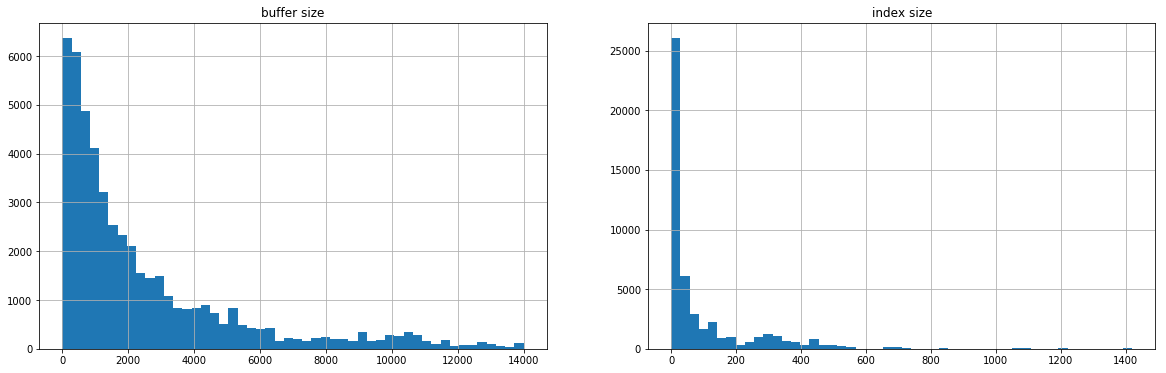

In [21]:
# Histograms of buffer size and index size

plt.figure(figsize=(20,6))
plt.subplot(121)
df['buffer_size'].hist(bins=50)
plt.title('buffer size')
plt.subplot(122)
plt.title('index size')
df['index_value_count'].hist(bins=50)

Unique users: 548


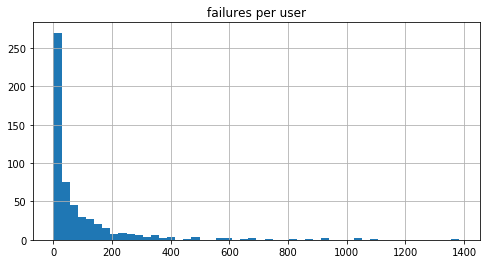

In [22]:
# Number of failures per user

plt.figure(figsize=(8,4))
failures_by_user = df.groupby('user_id').size()
print("Unique users: %d" % len(failures_by_user))
ax = failures_by_user.hist(bins=50)
plt.title('failures per user')
None